In [ ]:
!pip install opendatasets --quiet
import opendatasets as od

url = 'https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data/data'
od.download(url)

Skipping, found downloaded files in ".\climate-change-earth-surface-temperature-data" (use force=True to force download)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# I. По пунктам из задания

## 1. Подготовка данных

In [3]:
df = pd.read_csv('climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByCountry.csv')
df

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland
...,...,...,...,...
577457,2013-05-01,19.059,1.022,Zimbabwe
577458,2013-06-01,17.613,0.473,Zimbabwe
577459,2013-07-01,17.000,0.453,Zimbabwe
577460,2013-08-01,19.759,0.717,Zimbabwe


In [4]:
df_russia = df.loc[df['Country']=='Russia', df.columns]
df_russia['dt'] = pd.to_datetime(df['dt'])
df_russia = df_russia.set_index('dt').drop(columns='Country')
df_russia

,AverageTemperature,AverageTemperatureUncertainty
dt,,
1812-01-01,-27.114,4.336
1812-02-01,-25.644,4.394
1812-03-01,-19.108,4.171
1812-04-01,-7.605,4.286
1812-05-01,2.296,3.594
...,...,...
2013-05-01,6.313,0.396
2013-06-01,13.327,0.404
2013-07-01,16.051,0.409


In [5]:
df_russia.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2421 entries, 1812-01-01 to 2013-09-01
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   AverageTemperature             2405 non-null   float64
 1   AverageTemperatureUncertainty  2405 non-null   float64
dtypes: float64(2)
memory usage: 56.7 KB


In [6]:
#Заполним пропуски данными с предыдущего или следующего года
df_russia['AverageTemperature'] = (df_russia['AverageTemperature'].fillna(df_russia['AverageTemperature'].shift(12)).fillna(df_russia['AverageTemperature'].shift(-12)))
len(df_russia.loc[df_russia['AverageTemperature'].isna()==True])

0

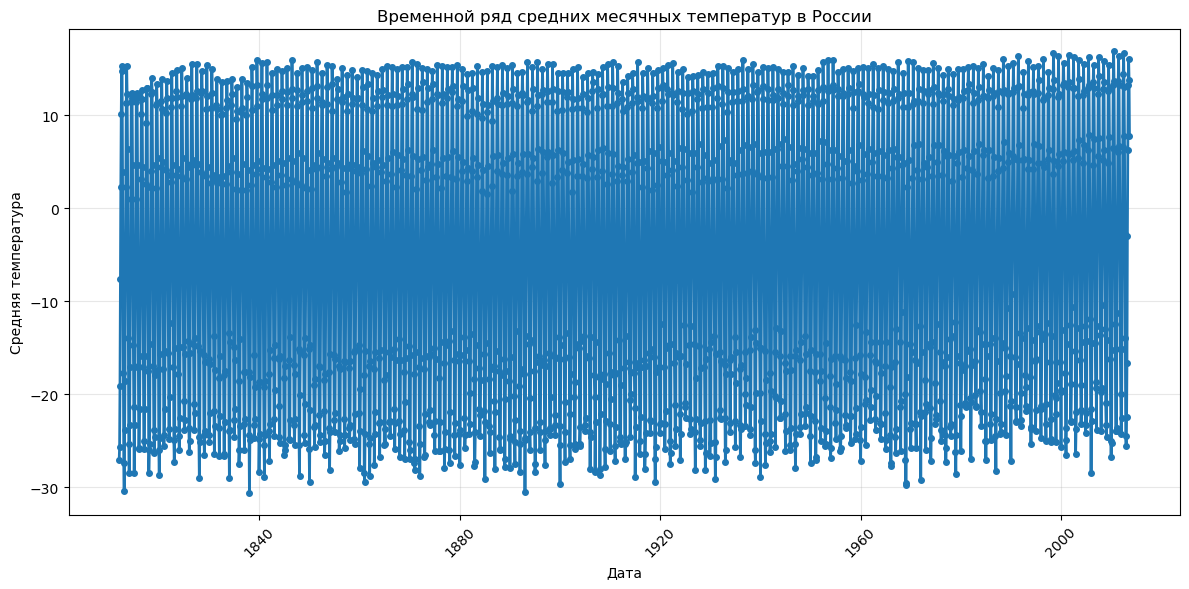

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(df_russia.index, df_russia['AverageTemperature'], marker='o', linewidth=2, markersize=4)
plt.title('Временной ряд средних месячных температур в России')
plt.xlabel('Дата')
plt.ylabel('Средняя температура')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

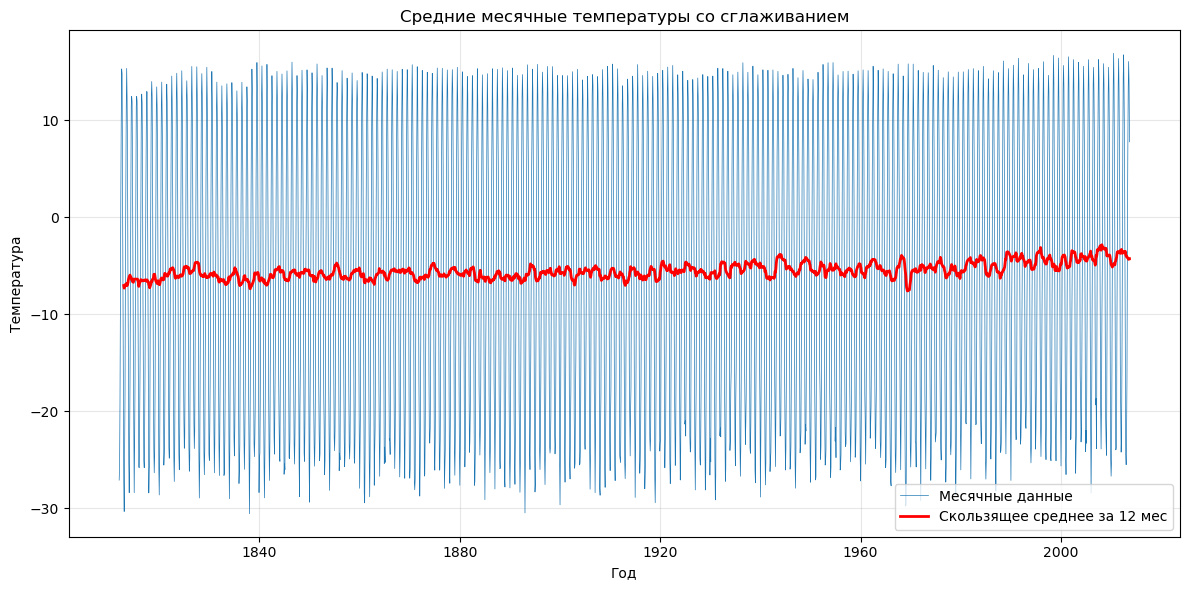

In [8]:
#Посмотрим скользящее среднее за 12 месяцев
df_russia['AverageTemperature_12m'] = df_russia['AverageTemperature'].rolling(window=12).mean()
plt.figure(figsize=(12, 6))
plt.plot(df_russia.index, df_russia['AverageTemperature'], linewidth=0.5, markersize=4, label='Месячные данные')
plt.plot(df_russia.index, df_russia['AverageTemperature_12m'], linewidth=2, color='red', label='Скользящее среднее за 12 мес')
plt.title('Средние месячные температуры со сглаживанием')
plt.xlabel('Год')
plt.ylabel('Температура')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2. Holdout-разбиение

In [9]:
df_russia_train = df_russia.iloc[:int(len(df_russia) * 0.8)]
df_russia_test = df_russia.iloc[int(len(df_russia) * 0.8):]
print(f"Обучающая выборка: {len(df_russia_train)} наблюдений")
print(f"Тестовая выборка: {len(df_russia_test)} наблюдений")
print(f"Train период: {df_russia_train.index.date.min()} - {df_russia_train.index.date.max()}")
print(f"Test период: {df_russia_test.index.date.min()} - {df_russia_test.index.date.max()}")

Обучающая выборка: 1936 наблюдений
Тестовая выборка: 485 наблюдений
Train период: 1812-01-01 - 1973-04-01
Test период: 1973-05-01 - 2013-09-01


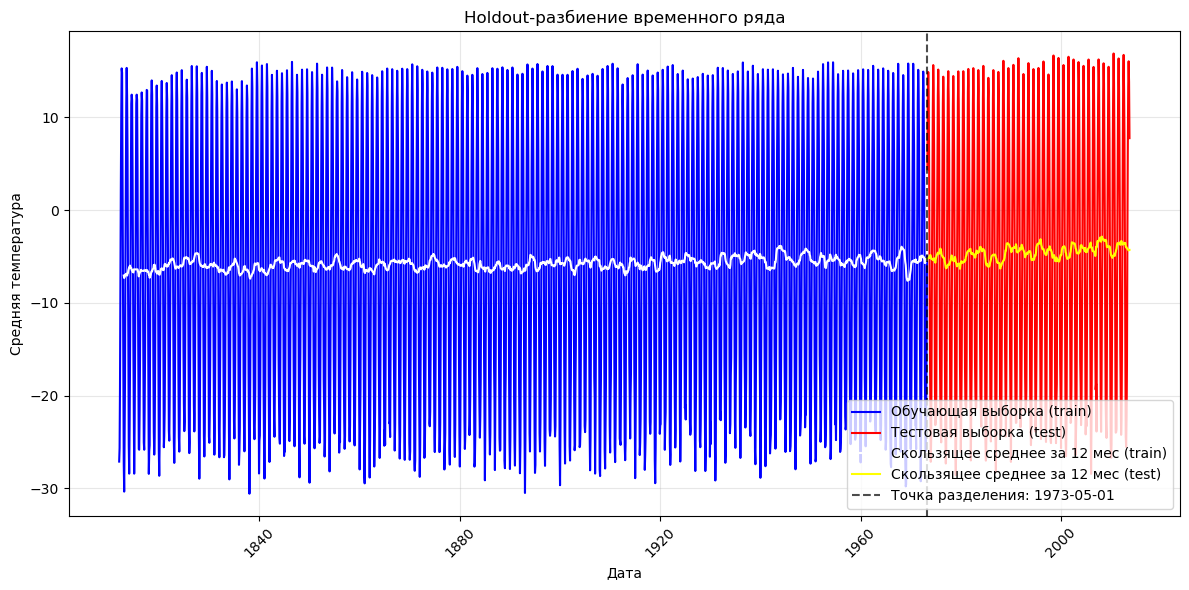

In [10]:
# Визуализация train/test разбиения
plt.figure(figsize=(12, 6))
plt.plot(df_russia_train.index, df_russia_train['AverageTemperature'], color='blue', label='Обучающая выборка (train)')
plt.plot(df_russia_test.index, df_russia_test['AverageTemperature'], color='red', label='Тестовая выборка (test)')
plt.plot(df_russia_train.index, df_russia_train['AverageTemperature_12m'], color='white', label='Скользящее среднее за 12 мес (train)')
plt.plot(df_russia_test.index, df_russia_test['AverageTemperature_12m'], color='yellow', label='Скользящее среднее за 12 мес (test)')
plt.axvline(x=df_russia_test.index[0], color='black', linestyle='--', alpha=0.7, label=f'Точка разделения: {df_russia_test.index[0].strftime("%Y-%m-%d")}')
plt.title('Holdout-разбиение временного ряда')
plt.xlabel('Дата')
plt.ylabel('Средняя температура')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Скользящее окно

Код из лекции плохо подходит для данной задачи, т.к плохо видно всё

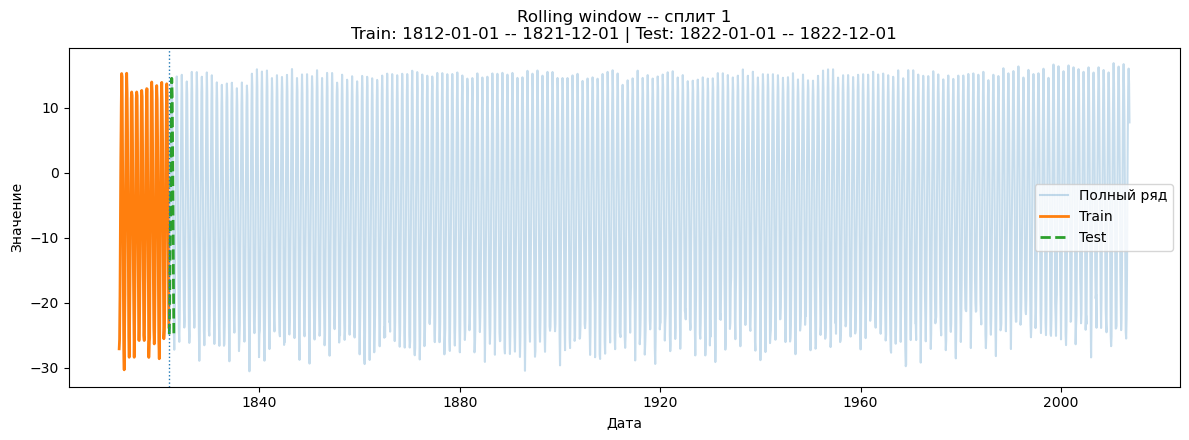

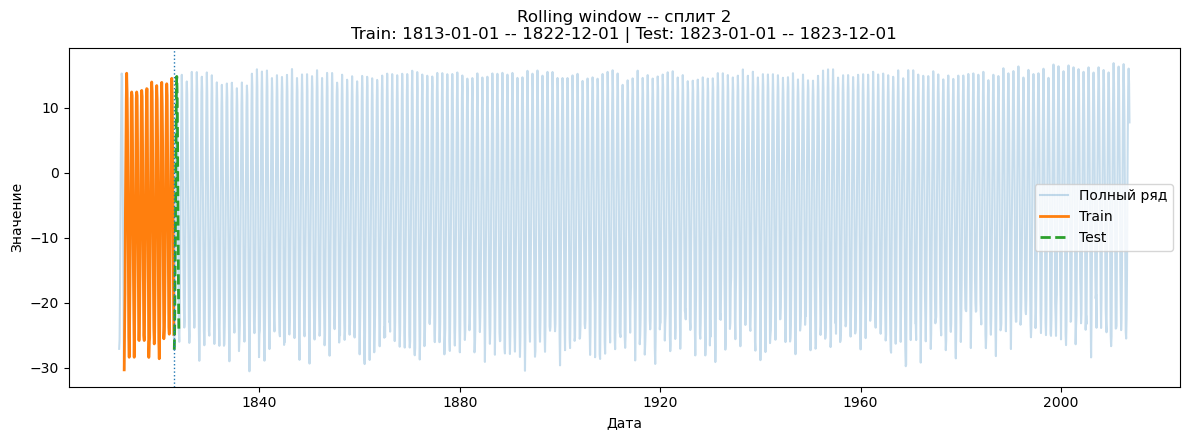

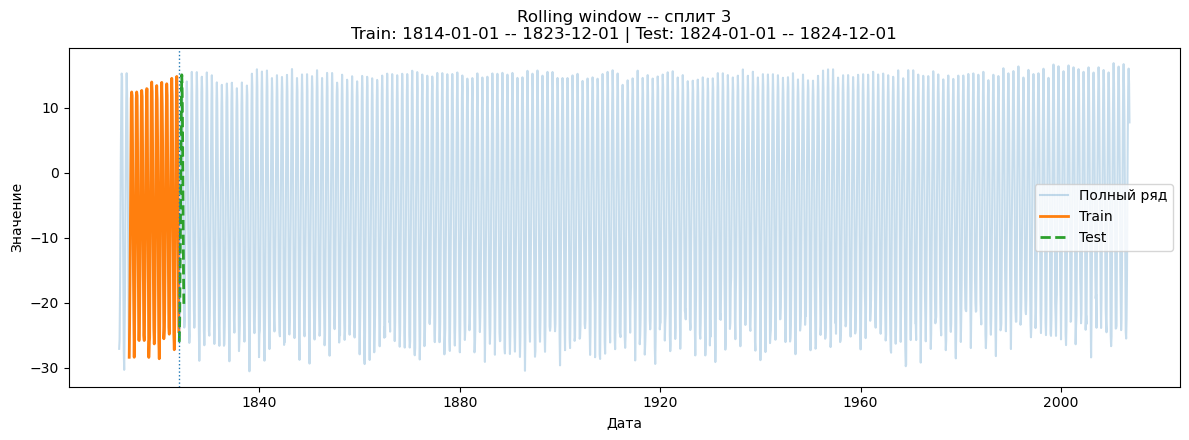

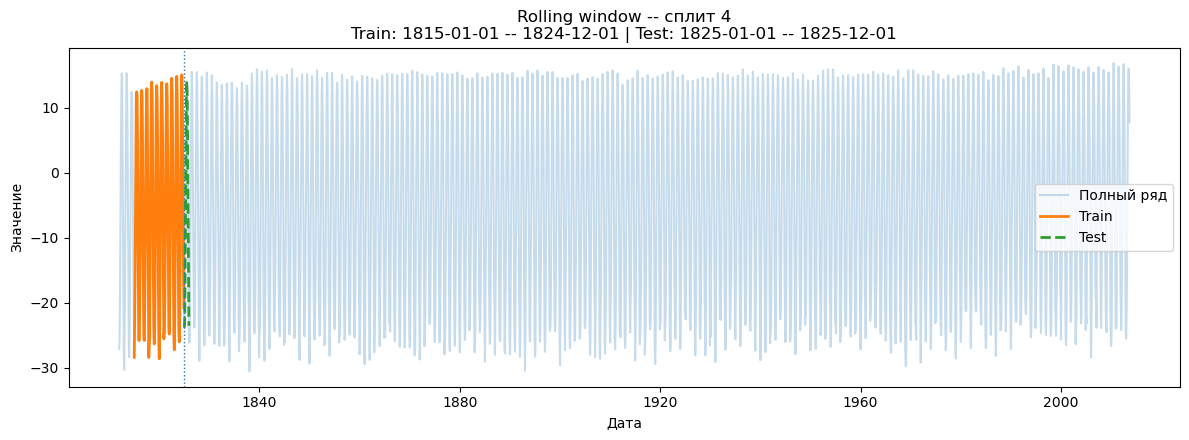

In [11]:
window_size = 120  # Месяцев для обучения
horizon = 12  	# Месяцев для прогноза
 
# Соберем окна
splits = []
for start in range(0, len(df_russia) - window_size - horizon + 1, horizon):
	train_window = df_russia.iloc[start:start+window_size]
	test_window = df_russia.iloc[start+window_size:start+window_size+horizon]
	splits.append((train_window, test_window))
 
# Рисуем первые четыре сплита
for i, (train_window, test_window) in enumerate(splits[:4], start=1):
	plt.figure(figsize=(12, 4.5))
	
	# Весь ряд — фоном
	plt.plot(df_russia.index, df_russia['AverageTemperature'], alpha=0.25, label='Полный ряд')
	# Train
	plt.plot(train_window.index, train_window['AverageTemperature'], linewidth=2, label='Train')
	# Test
	plt.plot(test_window.index, test_window['AverageTemperature'], linewidth=2, linestyle='--', label='Test')
	# Вертикальная линия-раздел
	plt.axvline(test_window.index[0], linestyle=':', linewidth=1)
 
	plt.title(f'Rolling window -- сплит {i}\n'
          	f'Train: {train_window.index[0].date()} -- {train_window.index[-1].date()} | '
          	f'Test: {test_window.index[0].date()} -- {test_window.index[-1].date()}')
	plt.xlabel('Дата')
	plt.ylabel('Значение')
	plt.legend()
	plt.tight_layout()
	plt.show()

Немного перепишем

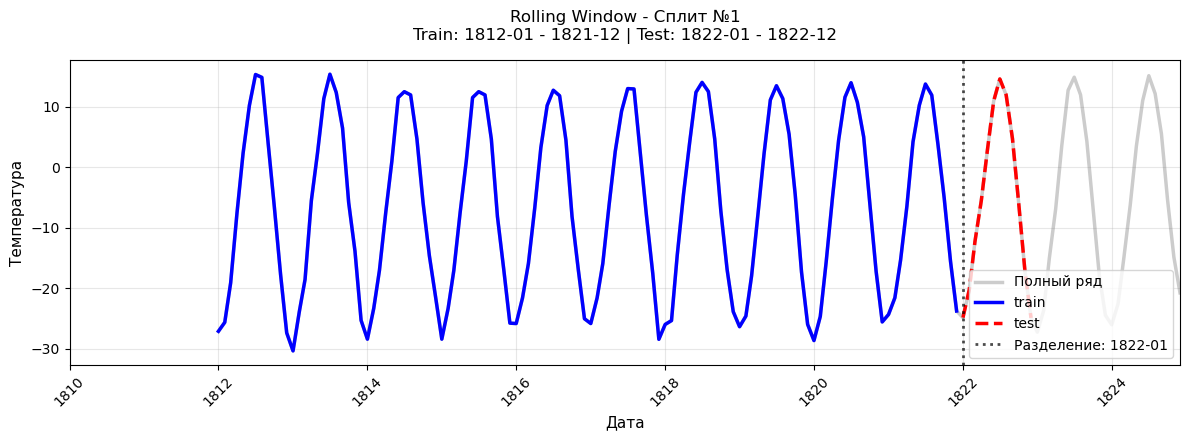

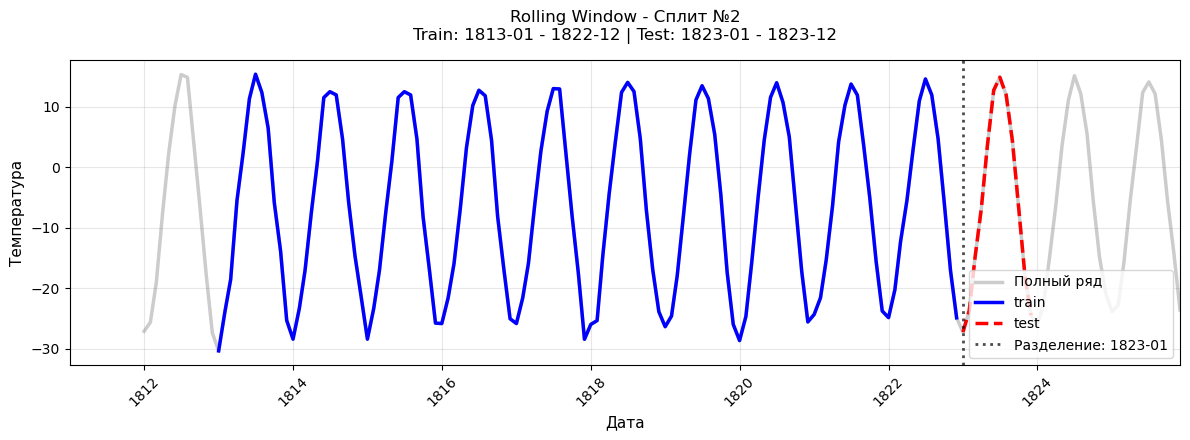

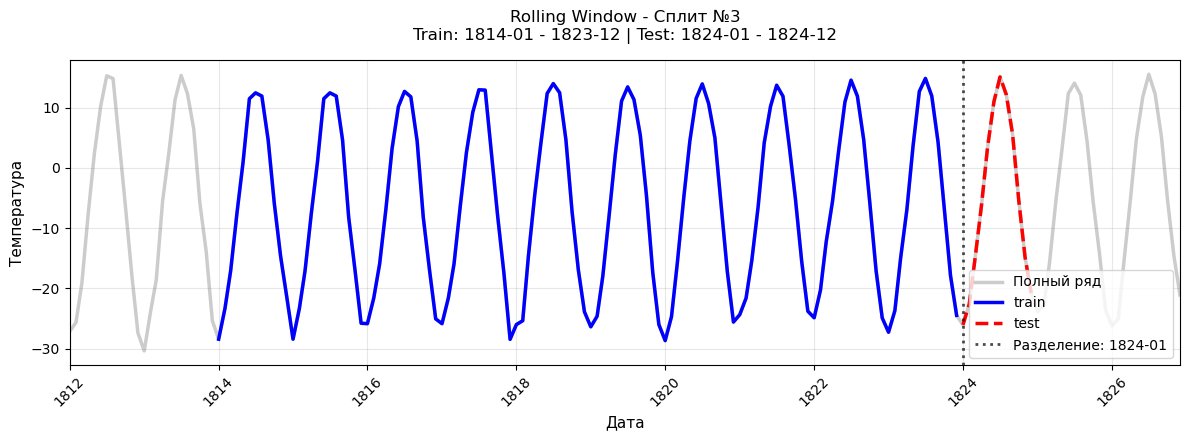

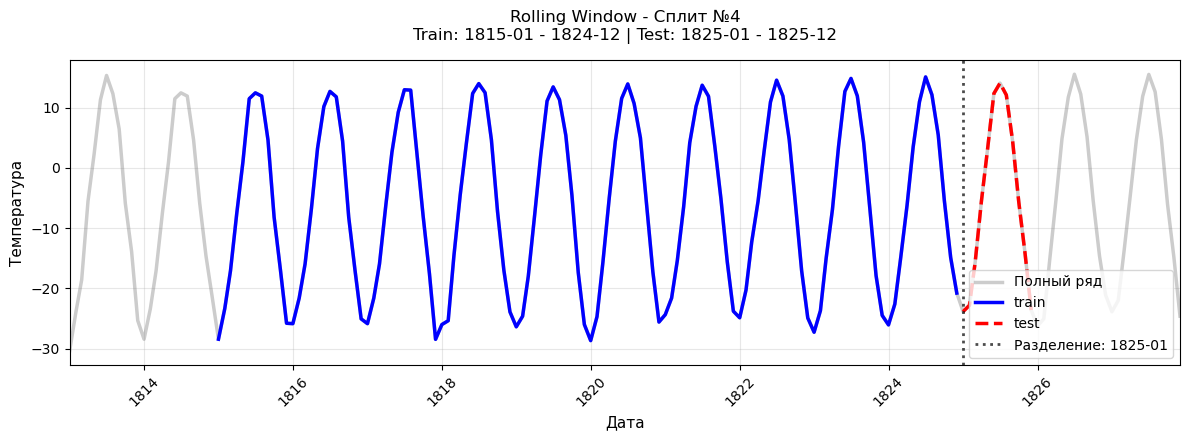

In [12]:
window_size = 120  # Месяцев для обучения
horizon = 12  	# Месяцев для прогноза

# Соберем окна
splits = []
for start in range(0, len(df_russia) - window_size - horizon + 1, horizon):
    train_window = df_russia.iloc[start:start+window_size]
    test_window = df_russia.iloc[start+window_size:start+window_size+horizon]
    splits.append((train_window, test_window))

for i, (train_window, test_window) in enumerate(splits[:4], start=1):
    plt.figure(figsize=(12, 4.5))
    left_lim = train_window.index[0] - pd.DateOffset(years=2)
    right_lim = test_window.index[-1] + pd.DateOffset(years=2)
    df_russia_lim = df_russia[(df_russia.index >= left_lim) & (df_russia.index <= right_lim)]
    
    # Фон
    plt.plot(df_russia_lim.index, df_russia_lim['AverageTemperature'], color='gray', linewidth=2.5, alpha=0.4, label='Полный ряд')
    
    # train
    plt.plot(train_window.index, train_window['AverageTemperature'], color='blue', linewidth=2.5, label='train')
    
    # test
    plt.plot(test_window.index, test_window['AverageTemperature'], color='red', linewidth=2.5, linestyle='--', label='test')
    
    # Линия, разделяющая train/test
    plt.axvline(test_window.index[0], color='black', linestyle=':', linewidth=2, alpha=0.7, label=f'Разделение: {test_window.index[0].strftime("%Y-%m")}')
    
    plt.title(f'Rolling Window - Сплит №{i}\n'
              f'Train: {train_window.index[0].strftime("%Y-%m")} - {train_window.index[-1].strftime("%Y-%m")} | '
              f'Test: {test_window.index[0].strftime("%Y-%m")} - {test_window.index[-1].strftime("%Y-%m")}',
              fontsize=12, pad=15)
    plt.xlabel('Дата', fontsize=11)
    plt.ylabel('Температура', fontsize=11)
    plt.legend(fontsize=10, loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.xlim(left_lim, right_lim)
    plt.tight_layout()
    plt.show()

## 4. Генерация признаков

In [13]:
df_russia_train['lag_1'] = df_russia_train['AverageTemperature'].shift(1)
df_russia_train['lag_12'] = df_russia_train['AverageTemperature'].shift(12)
df_russia_train['month'] = df_russia_train.index.month
df_russia_train['is_winter'] = df_russia_train['month'].isin([12, 1, 2]).astype(int)
df_russia_train['is_summer'] = df_russia_train['month'].isin([6, 7, 8]).astype(int)
df_russia_train = df_russia_train.dropna()
df_russia_train

C:\Users\Игнат\AppData\Local\Temp\ipykernel_8608\1639290800.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_russia_train['lag_1'] = df_russia_train['AverageTemperature'].shift(1)
C:\Users\Игнат\AppData\Local\Temp\ipykernel_8608\1639290800.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_russia_train['lag_12'] = df_russia_train['AverageTemperature'].shift(12)
C:\Users\Игнат\AppData\Local\Temp\ipykernel_8608\1639290800.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

,AverageTemperature,AverageTemperatureUncertainty,AverageTemperature_12m,lag_1,lag_12,month,is_winter,is_summer
dt,,,,,,,,
1813-01-01,-30.351,4.698,-7.316583,-27.375,-27.114,1,1,0
1813-02-01,-23.850,4.498,-7.167083,-30.351,-25.644,2,1,0
1813-03-01,-18.561,5.741,-7.121500,-23.850,-19.108,3,0,0
1813-04-01,-5.516,3.820,-6.947417,-18.561,-7.605,4,0,0
1813-06-01,11.295,3.450,-6.856167,2.296,10.200,6,0,1
...,...,...,...,...,...,...,...,...
1972-12-01,-21.875,0.235,-5.702000,-18.503,-21.908,12,1,0
1973-01-01,-25.958,0.316,-5.429000,-21.875,-29.234,1,1,0
1973-02-01,-21.007,0.295,-5.318167,-25.958,-22.337,2,1,0


In [14]:
# Для тестовых данных также создаем признаки
df_russia_test['lag_1'] = df_russia_test['AverageTemperature'].shift(1)
df_russia_test['lag_12'] = df_russia_test['AverageTemperature'].shift(12)
df_russia_test['month'] = df_russia_test.index.month
df_russia_test['is_winter'] = df_russia_test['month'].isin([12, 1, 2]).astype(int)
df_russia_test = df_russia_test.dropna()
df_russia_test

C:\Users\Игнат\AppData\Local\Temp\ipykernel_8608\508133395.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_russia_test['lag_1'] = df_russia_test['AverageTemperature'].shift(1)
C:\Users\Игнат\AppData\Local\Temp\ipykernel_8608\508133395.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_russia_test['lag_12'] = df_russia_test['AverageTemperature'].shift(12)
C:\Users\Игнат\AppData\Local\Temp\ipykernel_8608\508133395.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

,AverageTemperature,AverageTemperatureUncertainty,AverageTemperature_12m,lag_1,lag_12,month,is_winter
dt,,,,,,,
1974-05-01,3.536,0.250,-5.304750,-5.146,4.416,5,0
1974-06-01,11.228,0.156,-5.398000,3.536,12.347,6,0
1974-07-01,15.644,0.146,-5.335583,11.228,14.895,7,0
1974-08-01,13.073,0.263,-5.307500,15.644,12.736,8,0
1974-09-01,6.873,0.213,-5.196750,13.073,5.544,9,0
...,...,...,...,...,...,...,...
2013-04-01,-2.986,0.444,-4.175333,-16.670,-2.503,4,0
2013-05-01,6.313,0.396,-4.198750,-2.986,6.594,5,0
2013-06-01,13.327,0.404,-4.291583,6.313,14.441,6,0


## 5. Оценка прогноза

In [15]:
X_train = df_russia_train[['lag_1', 'lag_12', 'month', 'is_winter']]
y_train = df_russia_train['AverageTemperature']
X_test = df_russia_test[['lag_1', 'lag_12', 'month', 'is_winter']]
y_test = df_russia_test['AverageTemperature']

y_pred = LinearRegression().fit(X_train, y_train).predict(X_test)

print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"MAPE: {np.mean(np.abs((y_test - y_pred) / y_test)) * 100}")
print(f"R^2: {r2_score(y_test, y_pred)}")

MAE: 1.5653650634936565
RMSE: 2.1163255081798584
MAPE: 17.656617473303925
R^2: 0.9782736691039298


Модель демонстрирует отличное качество прогнозирования  
Высокий R^2 свидетельствует о том, что выбранные признаки (лаги и сезонность) хорошо объясняют закономерности температурных изменений  
Средняя ошибка прогноза составляет менее 2 градусов  
Стандартное отклонение ошибок выше средней абсолютной ошибки, что указывает на наличие периодов, где модель ошибается сильнее

# II. Свободное творчество

## Поменяем порядок пунктов 2 и 4. Сделаем сначала генерацию признаков на всем датасете, а только потом сделаем split

In [16]:
df_russia['lag_1'] = df_russia['AverageTemperature'].shift(1)
df_russia['lag_12'] = df_russia['AverageTemperature'].shift(12)
df_russia['month'] = df_russia.index.month
df_russia['is_winter'] = df_russia['month'].isin([12, 1, 2]).astype(int)
df_russia['is_summer'] = df_russia['month'].isin([6, 7, 8]).astype(int)
df_russia = df_russia.dropna()


df_russia_train = df_russia.iloc[:int(len(df_russia) * 0.8)]
df_russia_test = df_russia.iloc[int(len(df_russia) * 0.8):]

X_train = df_russia_train[['lag_1', 'lag_12', 'month', 'is_winter']]
y_train = df_russia_train['AverageTemperature']
X_test = df_russia_test[['lag_1', 'lag_12', 'month', 'is_winter']]
y_test = df_russia_test['AverageTemperature']

y_pred = LinearRegression().fit(X_train, y_train).predict(X_test)

print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"MAPE: {np.mean(np.abs((y_test - y_pred) / y_test)) * 100}")
print(f"R^2: {r2_score(y_test, y_pred)}")

MAE: 1.5658735510361308
RMSE: 2.1142532062492814
MAPE: 17.55872892356299
R^2: 0.9783093784554342


## Видимо из-за фиксированных сдвигов во времени и получился идентичный результат